In [1]:
!pip install alibi

In [2]:
!pip install lime shap

In [3]:
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 4.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import shap
import lime
import lime.lime_tabular
import eli5
from eli5.sklearn import PermutationImportance
from alibi.explainers import ALE
from alibi.explainers import plot_ale
import matplotlib.pyplot as plt

In [4]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [6]:
X_scaled.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0     1.097064     -2.073335        1.269934   0.984375         1.568466   
1     1.829821     -0.353632        1.685955   1.908708        -0.826962   
2     1.579888      0.456187        1.566503   1.558884         0.942210   
3    -0.768909      0.253732       -0.592687  -0.764464         3.283553   
4     1.750297     -1.151816        1.776573   1.826229         0.280372   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0          3.283515        2.652874             2.532475       2.217515   
1         -0.487072       -0.023846             0.548144       0.001392   
2          1.052926        1.363478             2.037231       0.939685   
3          3.402909        1.915897             1.451707       2.867383   
4          0.539340        1.371011             1.428493      -0.009560   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0                2.255747  ...      1.886690      -1.359293         2.303601   
1               -0.868652  ...      1.805927      -0.369203         1.535126   
2               -0.398008  ...      1.511870      -0.023974         1.347475   
3                4.910919  ...     -0.281464       0.133984        -0.249939   
4               -0.562450  ...      1.298575      -1.466770         1.338539   

   worst area  worst smoothness  worst compactness  worst concavity  \
0    2.001237          1.307686           2.616665         2.109526   
1    1.890489         -0.375612          -0.430444        -0.146749   
2    1.456285          0.527407           1.082932         0.854974   
3   -0.550021          3.394275           3.893397         1.989588   
4    1.220724          0.220556          -0.313395         0.613179   

   worst concave points  worst symmetry  worst fractal dimension  
0              2.296076        2.750622                 1.937015  
1              1.087084       -0.243890                 0.281190  
2              1.955000        1.152255                 0.201391  
3              2.175786        6.046041                 4.935010  
4              0.729259       -0.868353                -0.397100  

[5 rows x 30 columns]

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, train_size=399, test_size=170, stratify=y, random_state=32)

In [8]:
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [10]:
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_val_lda = lda.transform(X_val)

In [11]:
svm_lda = SVC(kernel='rbf', probability=True, random_state=42)
svm_lda.fit(X_train_lda, y_train)

SVC(probability=True, random_state=42)

In [9]:
y_pred = svm.predict(X_val)
y_proba = svm.predict_proba(X_val)[:, 1]

In [13]:
y_pred_lda = svm_lda.predict(X_val_lda)
y_proba_lda = svm_lda.predict_proba(X_val_lda)[:, 1]

In [14]:
cm = confusion_matrix(y_val, y_pred_lda, labels=[1, 0])
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_val, y_pred_lda)
precision = precision_score(y_val, y_pred_lda, pos_label=0)
recall = recall_score(y_val, y_pred_lda, pos_label=0)
f1 = f1_score(y_val, y_pred_lda)
report = classification_report(y_val, y_pred_lda, target_names=data.target_names)

print("Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(report)

Performance Metrics:
Accuracy: 0.9706
Precision: 0.9677
Recall: 0.9524
F1 Score: 0.9767

Classification Report:
              precision    recall  f1-score   support

   malignant       0.97      0.95      0.96        63
      benign       0.97      0.98      0.98       107

    accuracy                           0.97       170
   macro avg       0.97      0.97      0.97       170
weighted avg       0.97      0.97      0.97       170



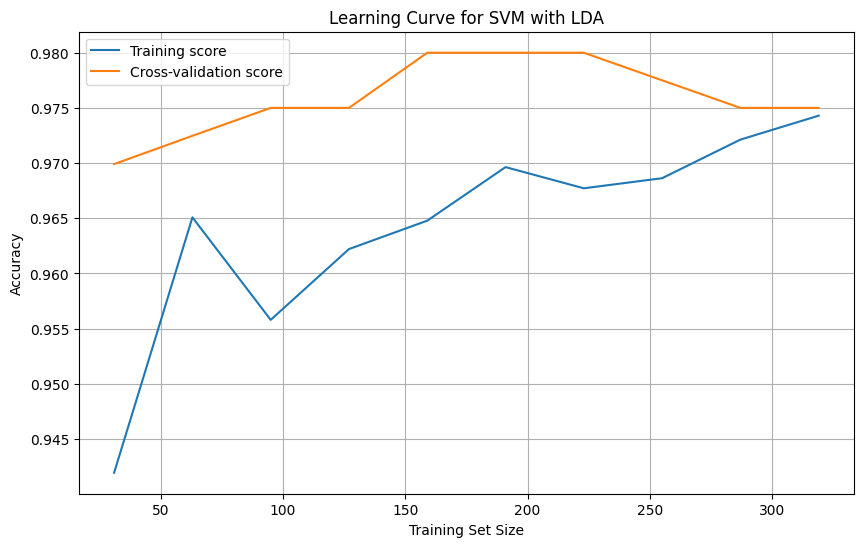

In [15]:
train_sizes, train_scores, val_scores = learning_curve(
    SVC(kernel='rbf', probability=True, random_state=42),
    X_train_lda, y_train,
    cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, val_scores_mean, label='Cross-validation score')
plt.title('Learning Curve for SVM with LDA')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

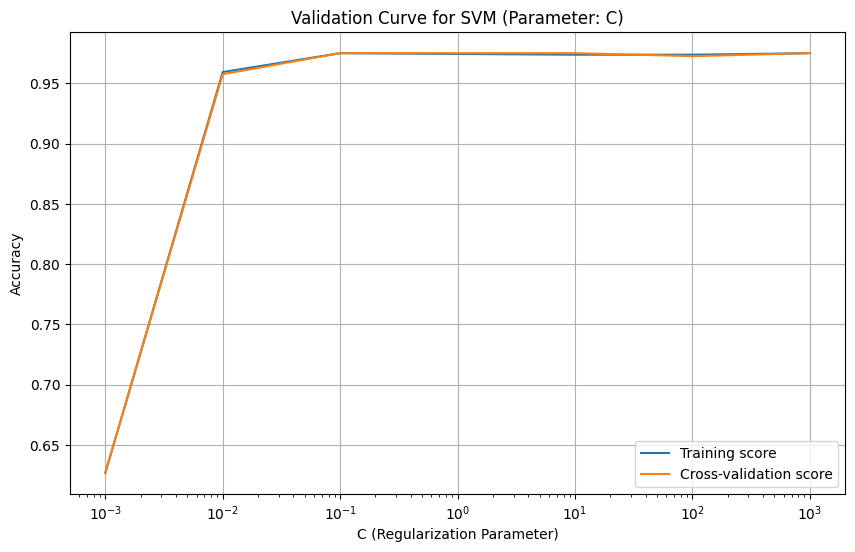

In [16]:
param_range = np.logspace(-3, 3, 7)
train_scores, val_scores = validation_curve(
    SVC(kernel='rbf', probability=True, random_state=42),
    X_train_lda, y_train,
    param_name='C', param_range=param_range,
    cv=5, scoring='accuracy',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.semilogx(param_range, train_scores_mean, label='Training score')
plt.semilogx(param_range, val_scores_mean, label='Cross-validation score')
plt.title('Validation Curve for SVM (Parameter: C)')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

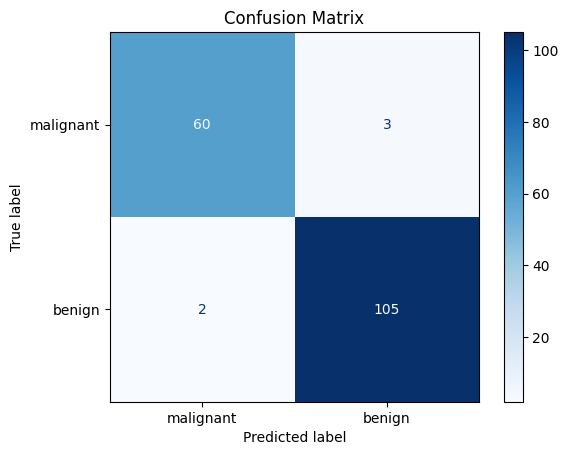

In [17]:
cm = confusion_matrix(y_val, y_pred_lda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

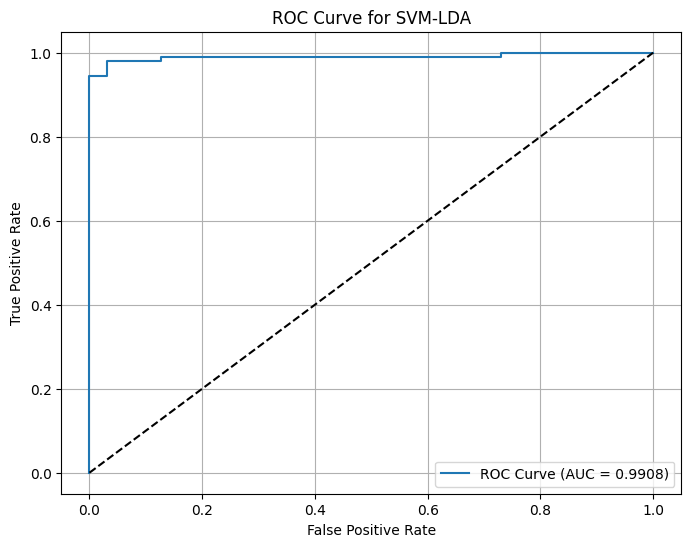

In [19]:
fpr, tpr, _ = roc_curve(y_val == 1, y_proba_lda)
roc_auc = roc_auc_score(y_val == 1, y_proba_lda)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM-LDA')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

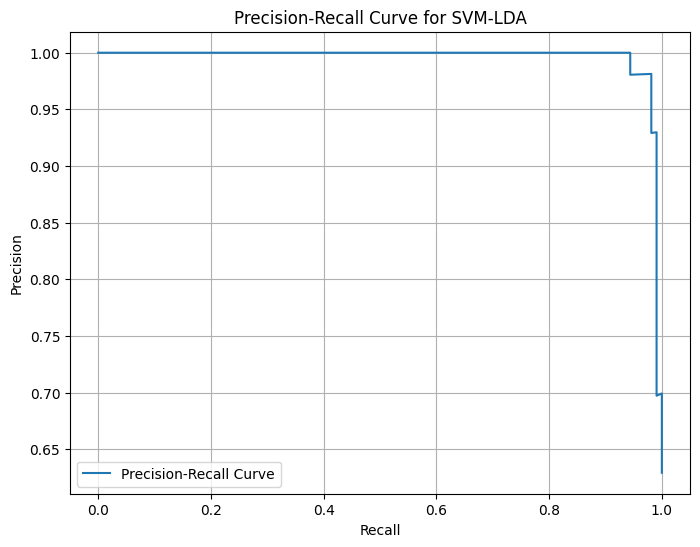

In [20]:
precision, recall, _ = precision_recall_curve(y_val, y_proba_lda)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for SVM-LDA')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

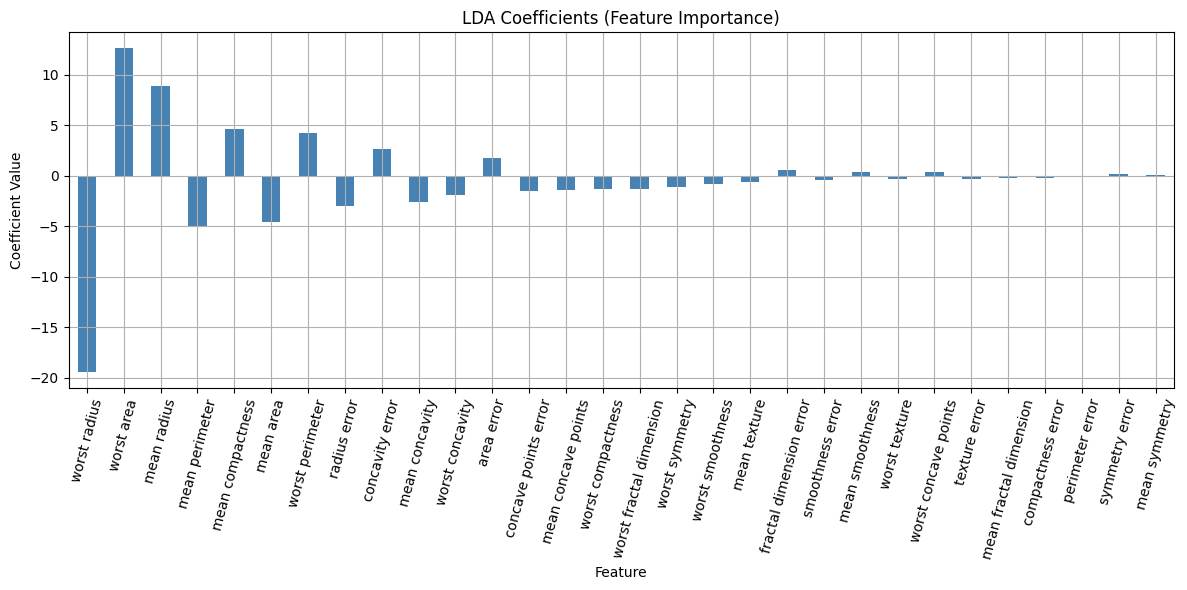

In [21]:
coefficients = pd.Series(lda.coef_[0], index=X.columns)
coefficients_sorted = coefficients.sort_values(key=abs, ascending=False)

plt.figure(figsize=(12, 6))
coefficients_sorted.plot(kind='bar', color='steelblue')
plt.title('LDA Coefficients (Feature Importance)')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=75)
plt.grid(True)
plt.tight_layout()
plt.show()

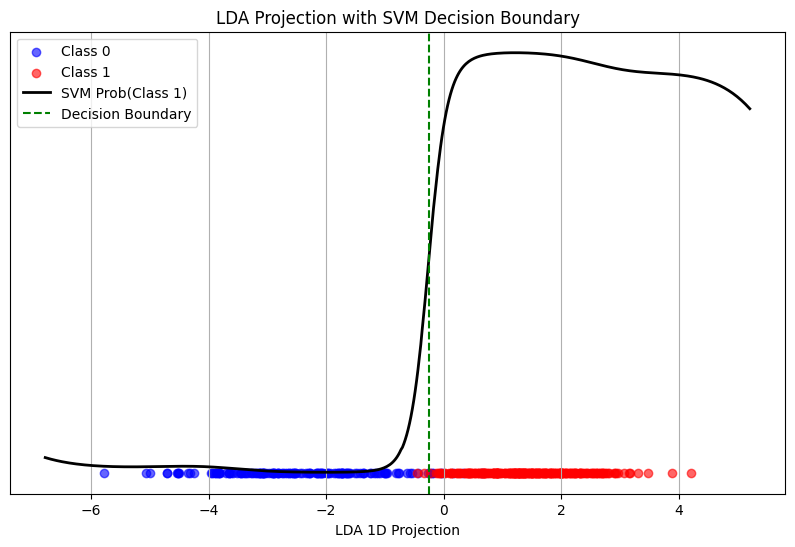

In [22]:
x_range = np.linspace(X_train_lda.min()-1, X_train_lda.max()+1, 500).reshape(-1, 1)
y_proba = svm_lda.predict_proba(x_range)[:, 1]

plt.figure(figsize=(10, 6))

plt.scatter(X_train_lda[y_train==0], np.zeros_like(X_train_lda[y_train==0]),color='blue', label='Class 0', alpha=0.6)
plt.scatter(X_train_lda[y_train==1], np.zeros_like(X_train_lda[y_train==1]),color='red', label='Class 1', alpha=0.6)

plt.plot(x_range, y_proba, color='black', label='SVM Prob(Class 1)', linewidth=2)
plt.axvline(x=x_range[np.argmin(np.abs(y_proba - 0.5))], color='green', linestyle='--', label='Decision Boundary')

plt.title('LDA Projection with SVM Decision Boundary')
plt.xlabel('LDA 1D Projection')
plt.yticks([])
plt.legend()
plt.grid(True)
plt.show()

In [23]:
from eli5.sklearn import PermutationImportance
import eli5

perm = PermutationImportance(svm, random_state=42).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X.columns.tolist())

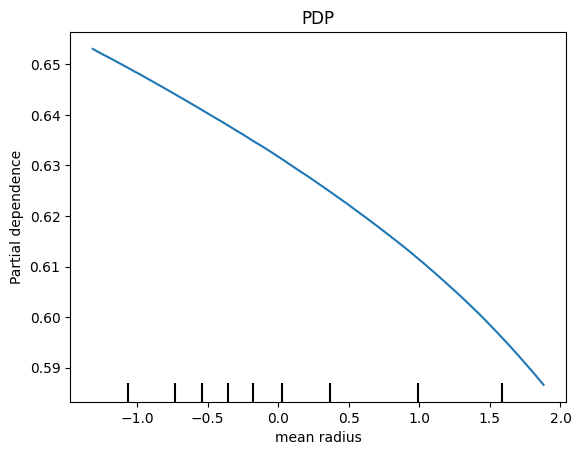

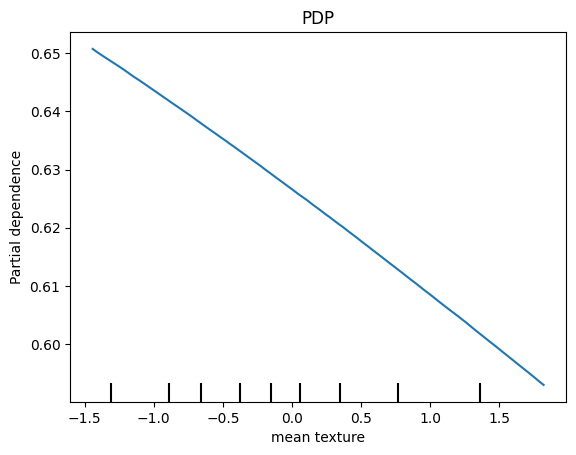

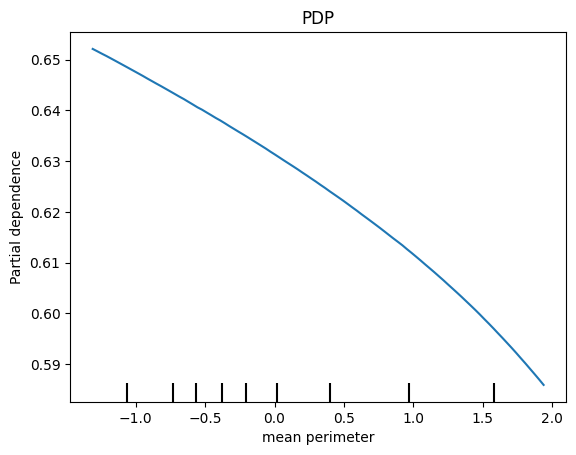

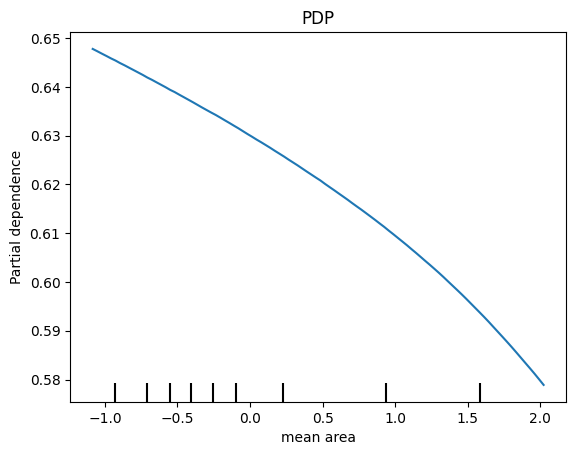

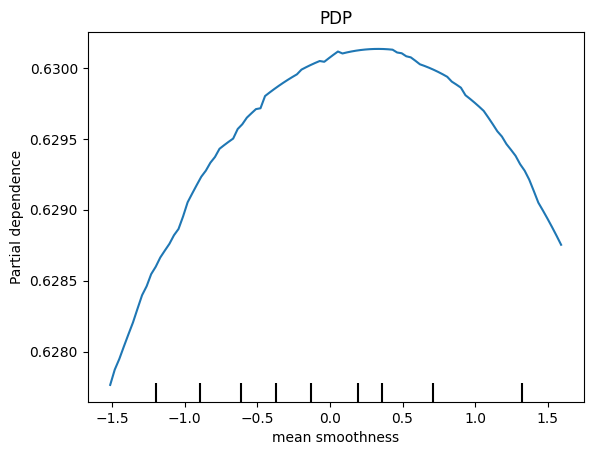

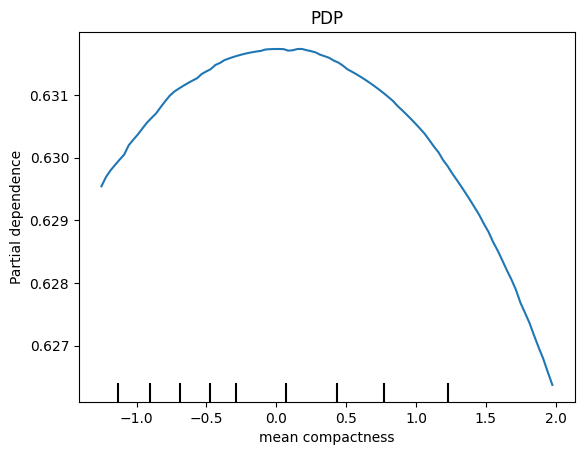

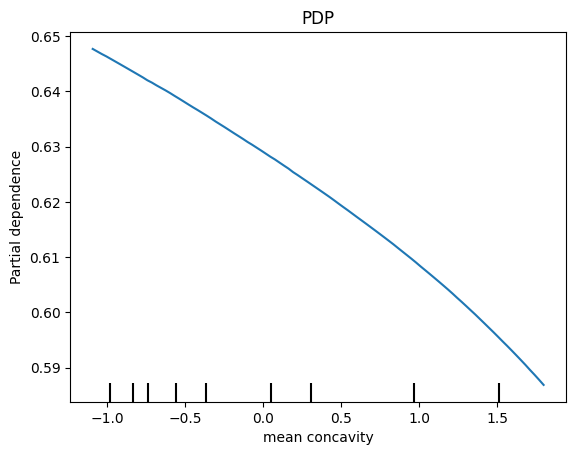

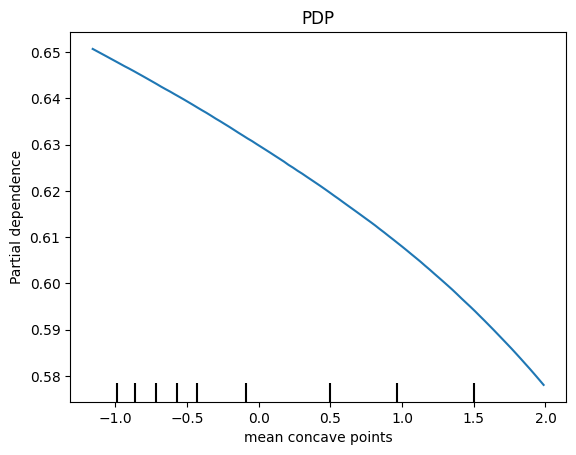

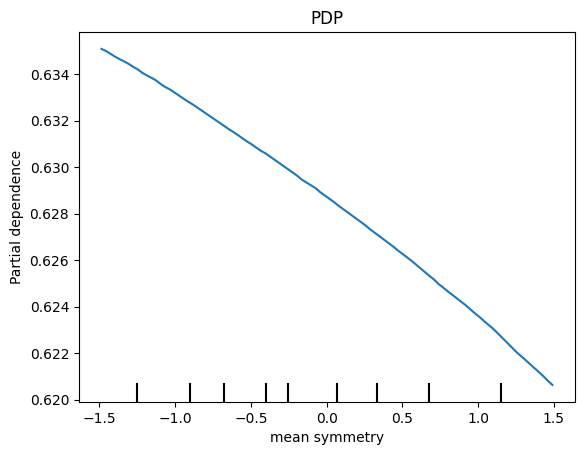

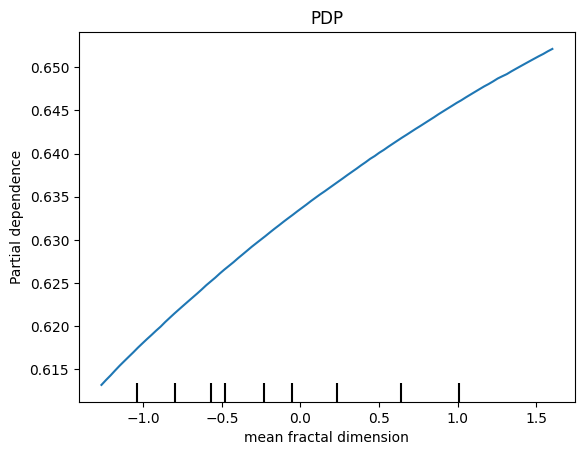

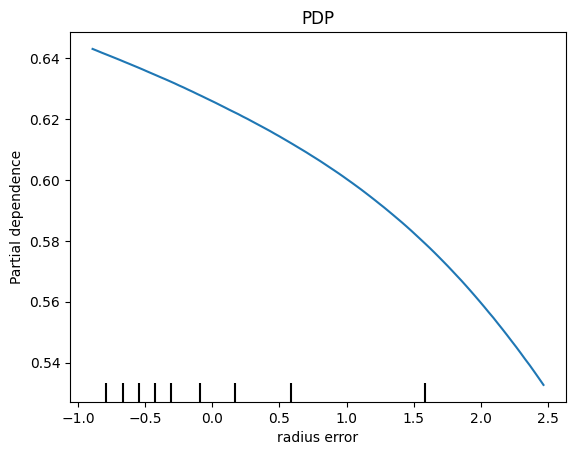

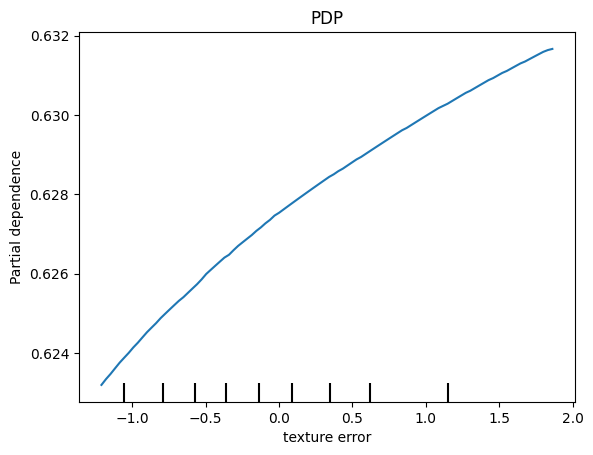

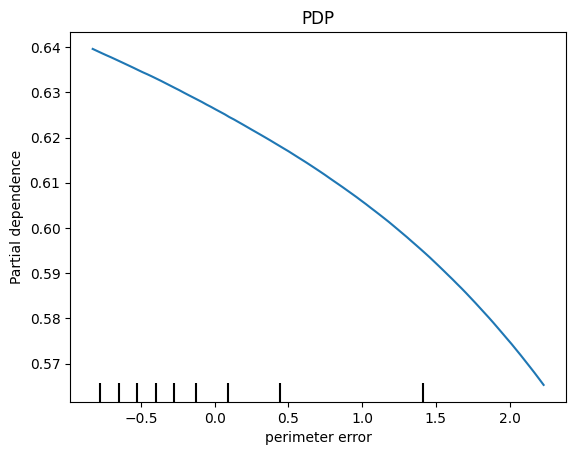

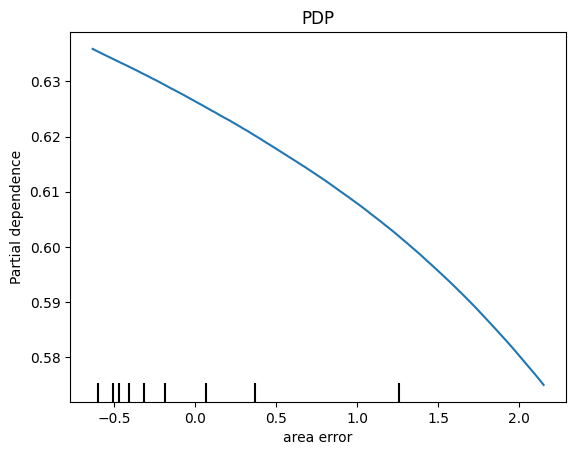

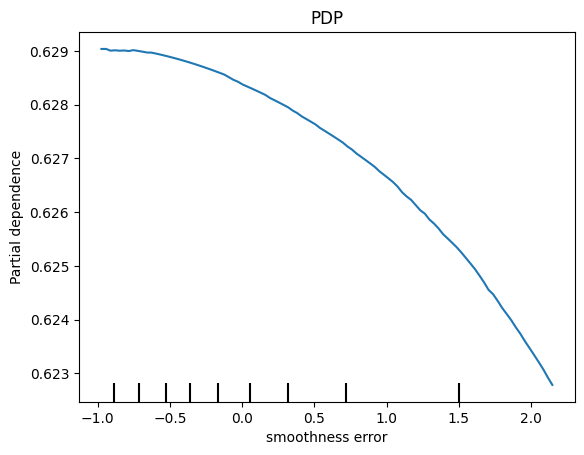

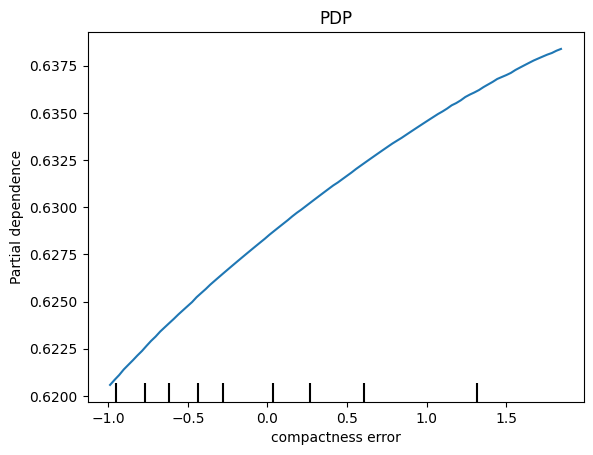

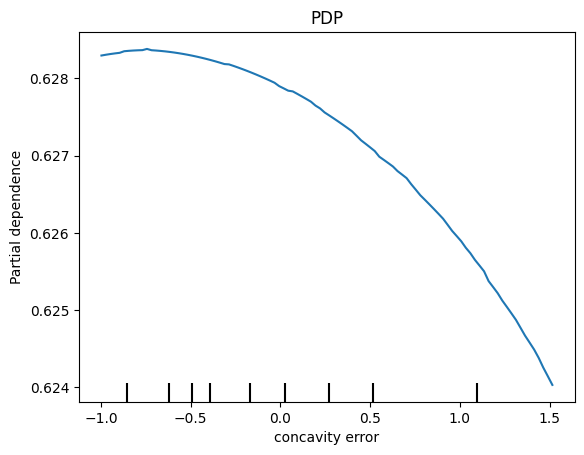

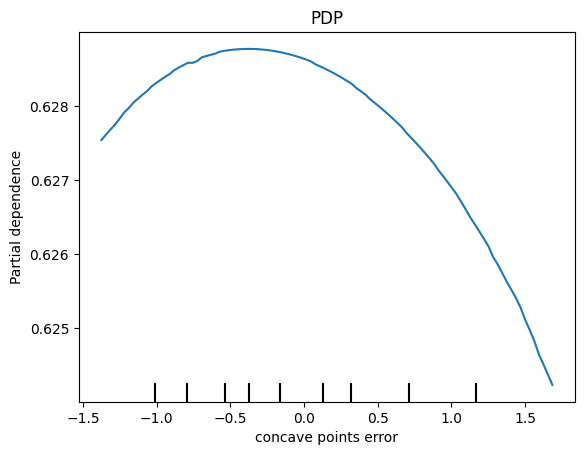

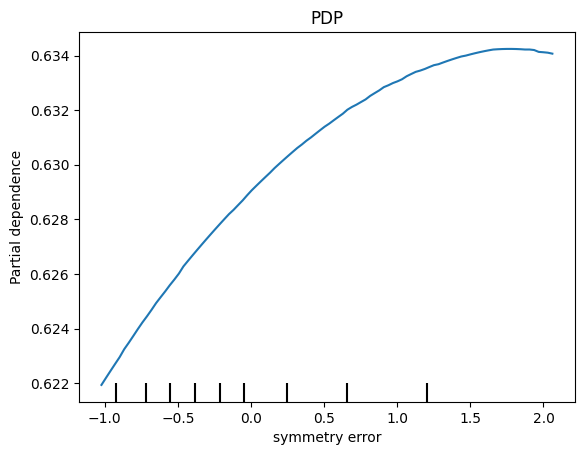

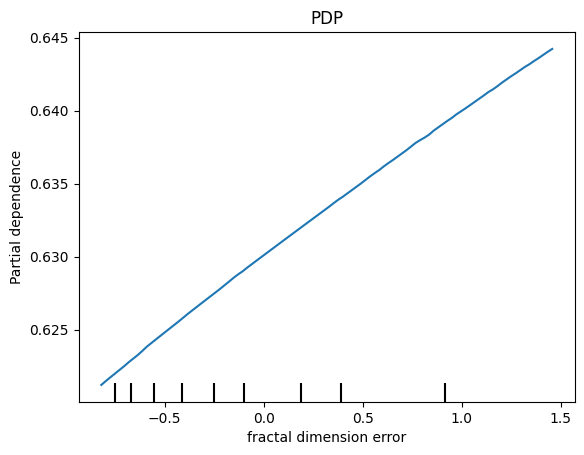

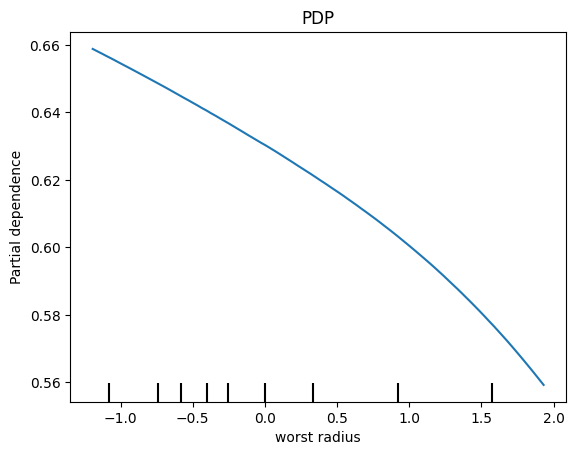

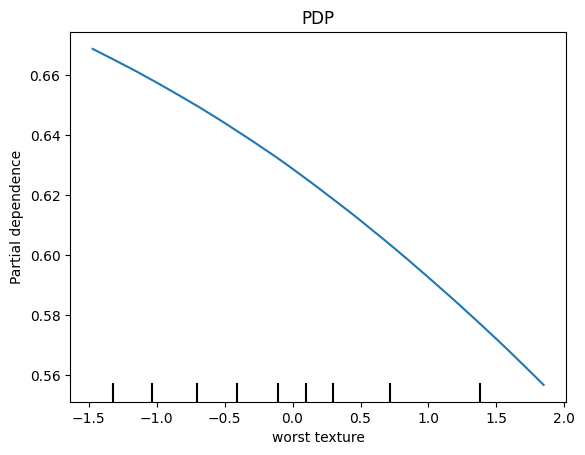

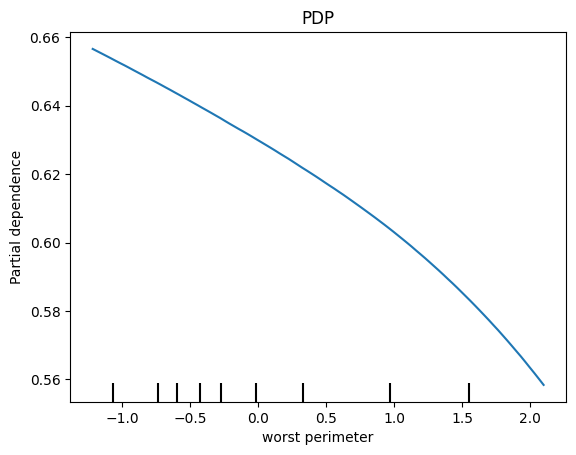

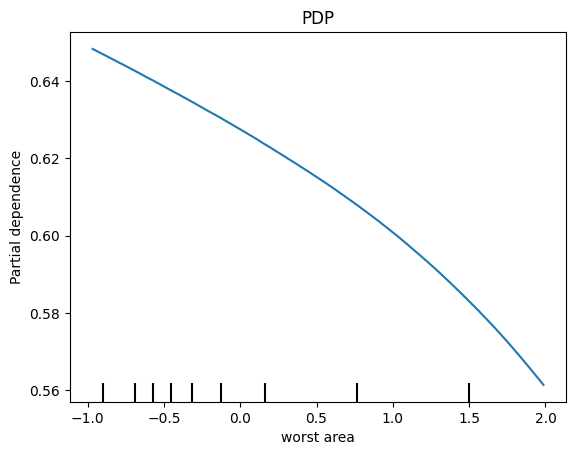

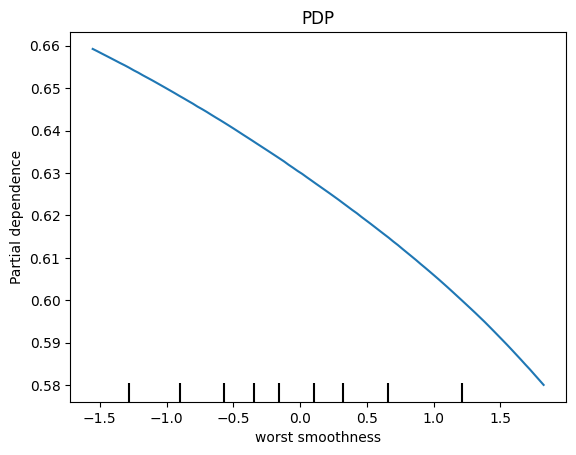

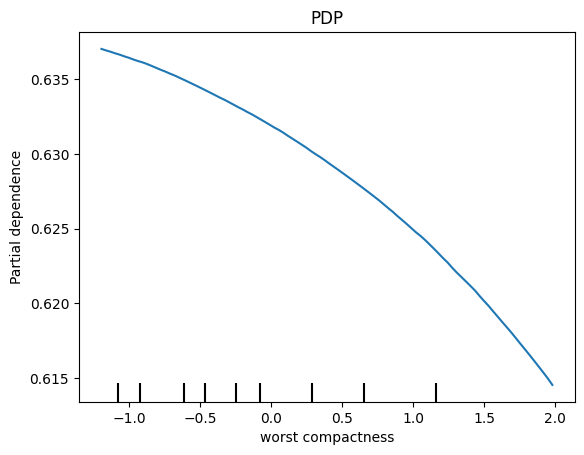

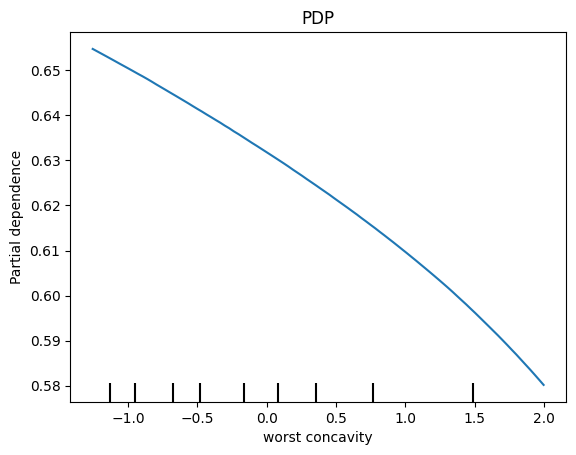

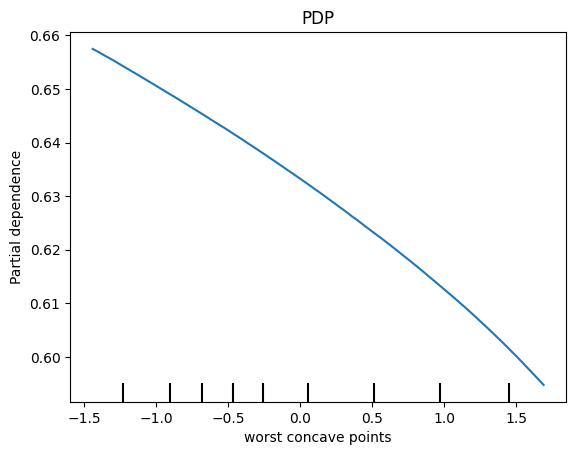

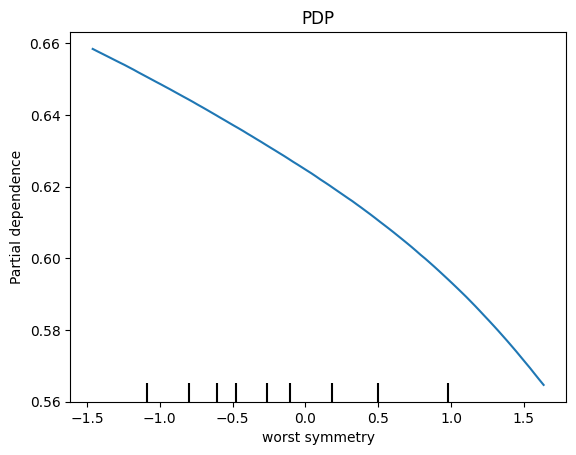

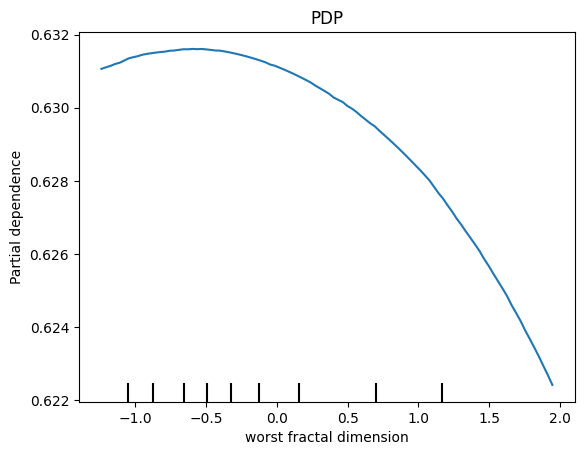

In [24]:
for feature in X.columns.tolist():
    PartialDependenceDisplay.from_estimator(svm, X_val, features=[feature], target=0, feature_names=X.columns.tolist())
    plt.title("PDP")
    plt.show()

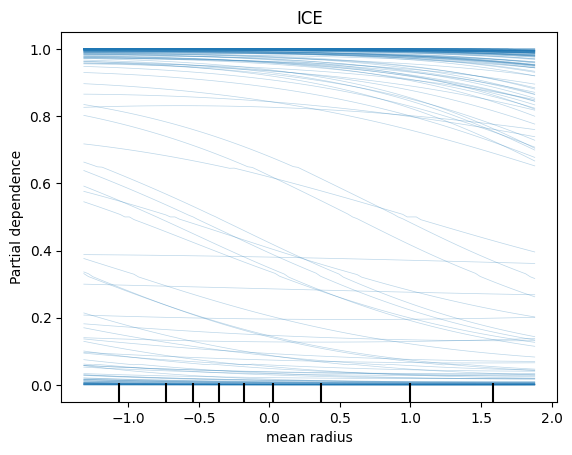

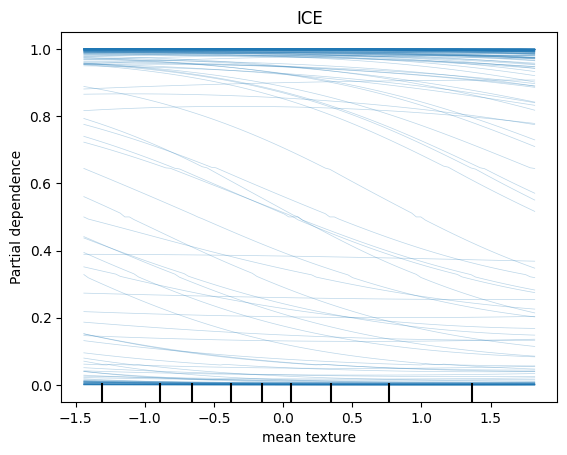

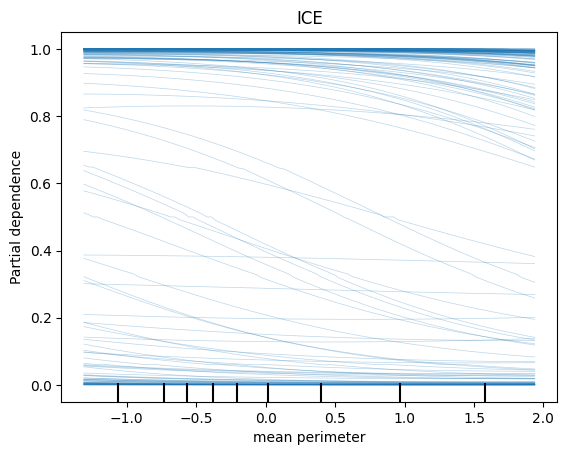

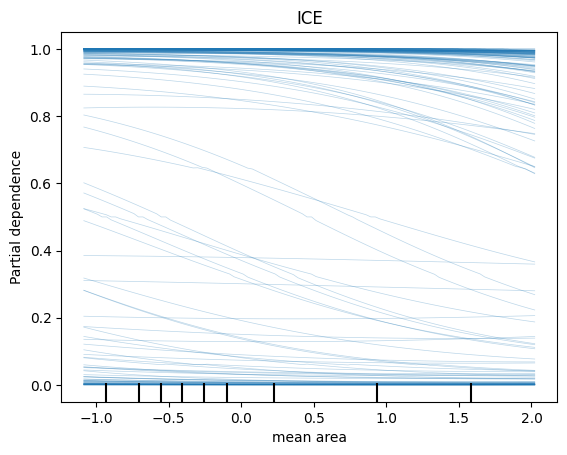

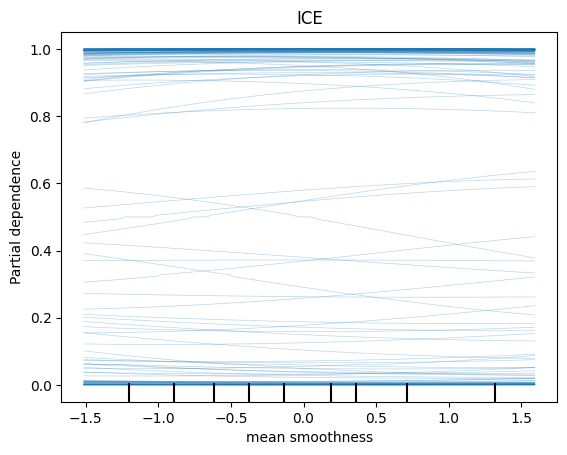

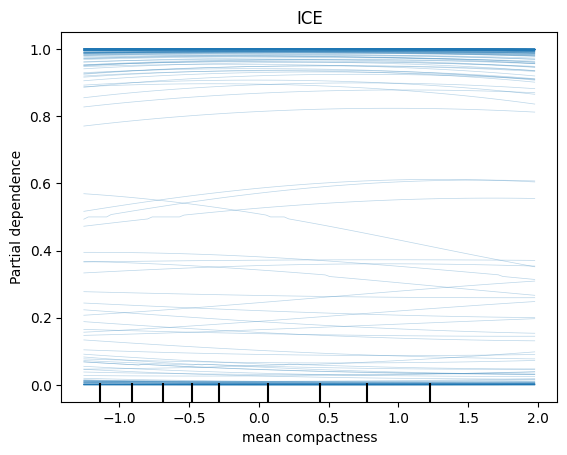

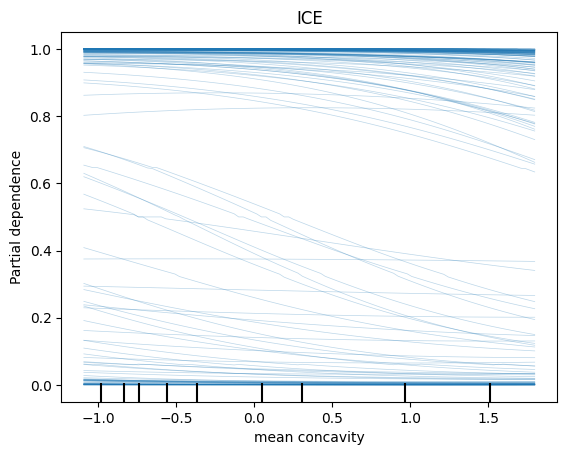

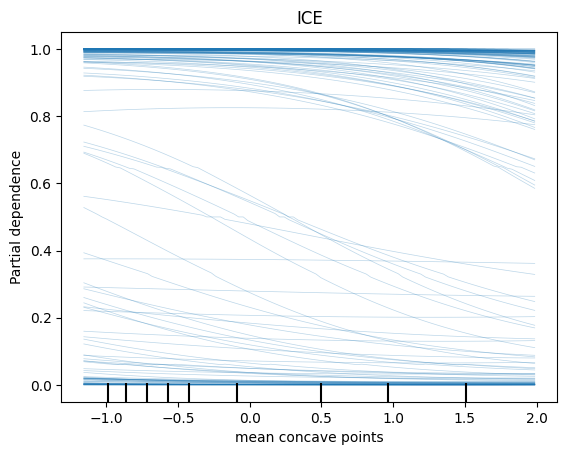

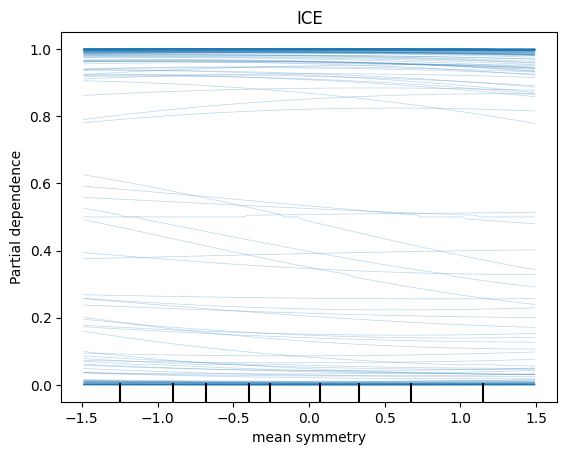

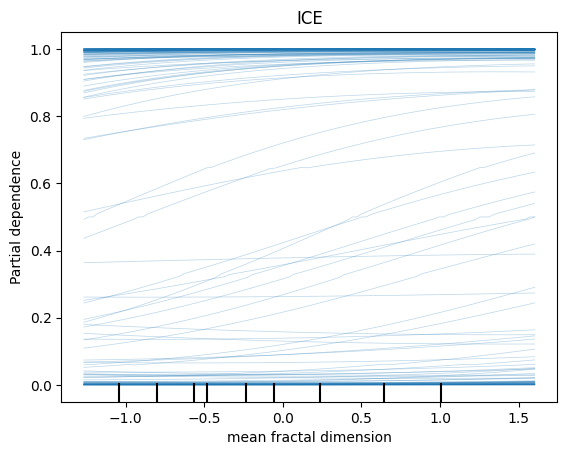

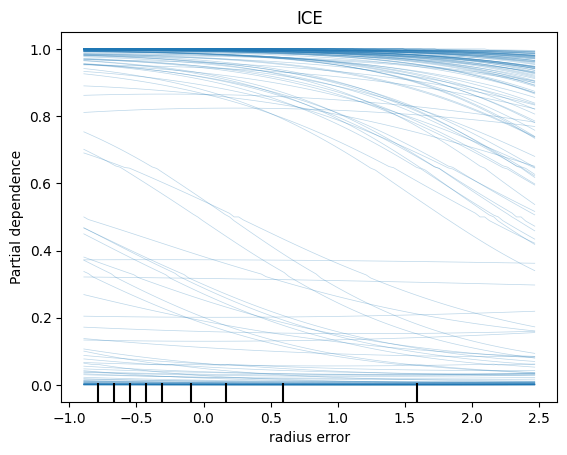

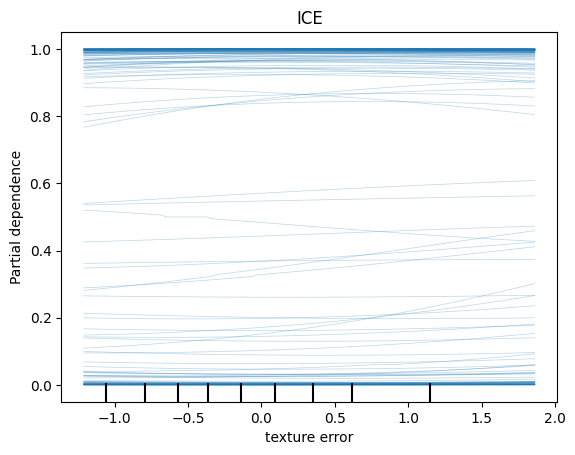

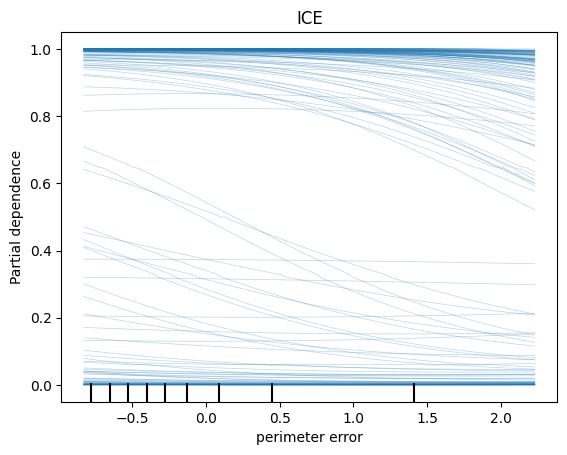

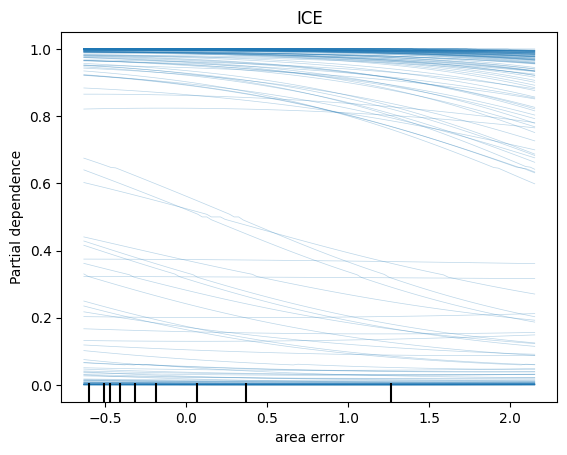

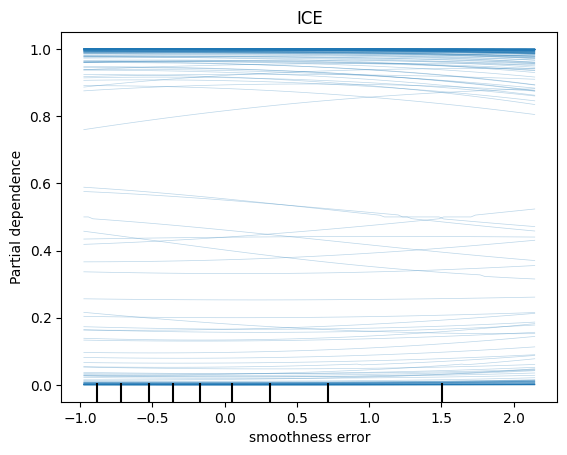

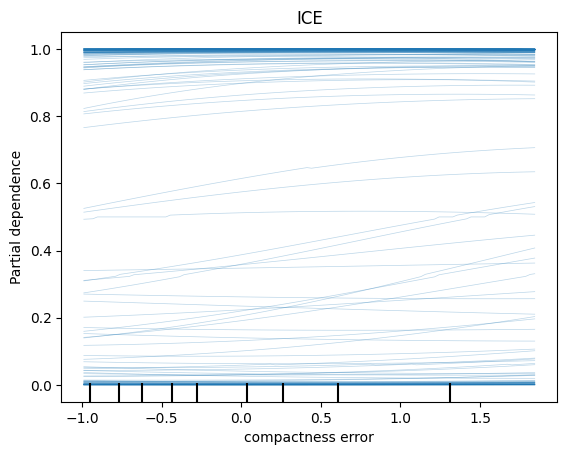

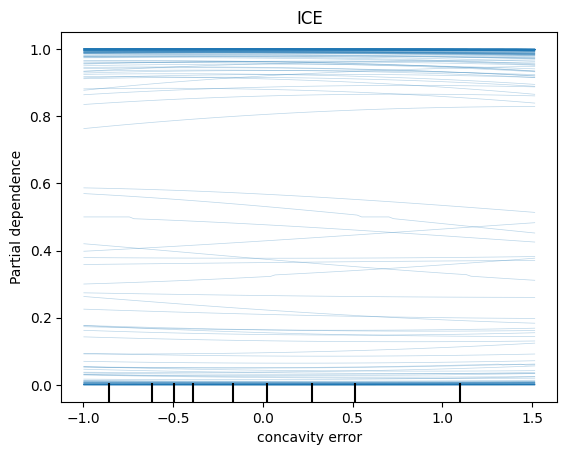

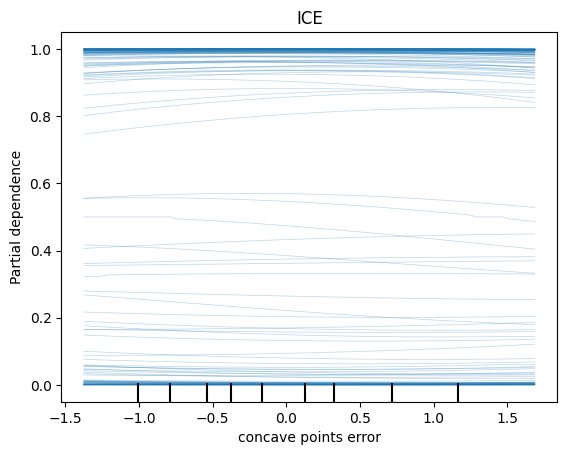

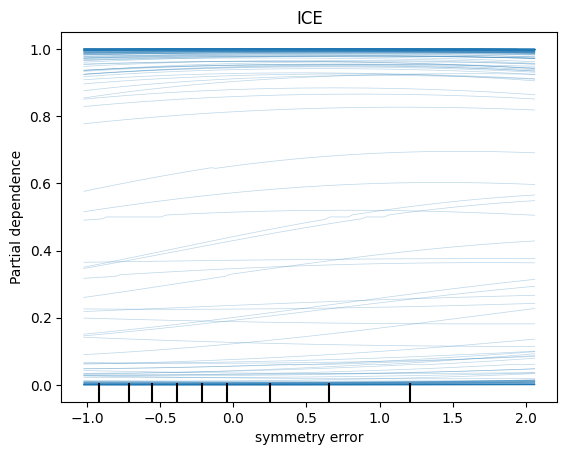

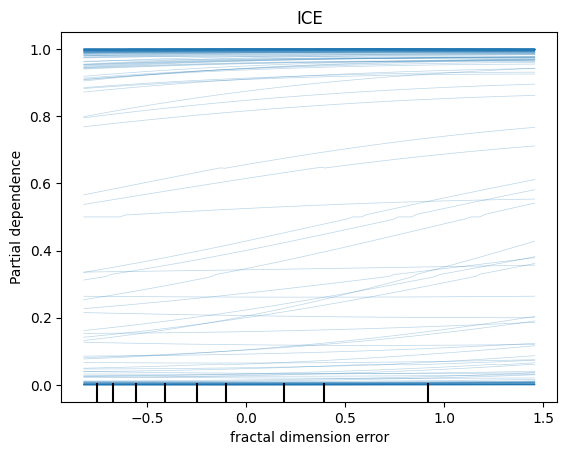

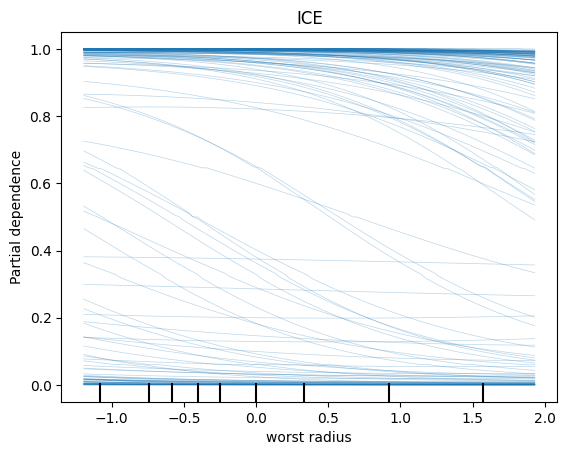

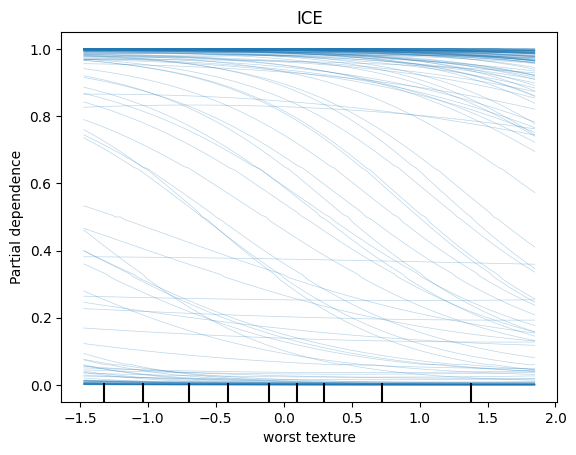

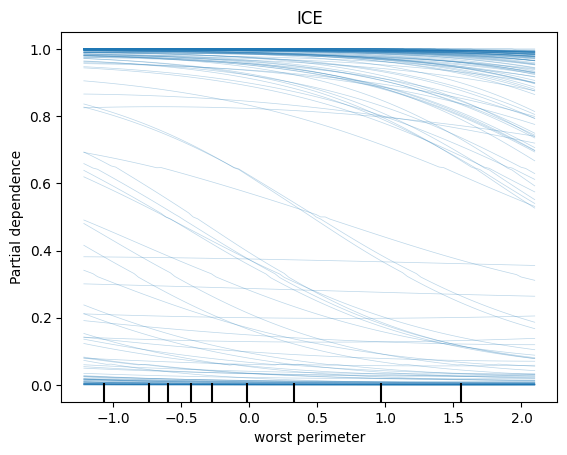

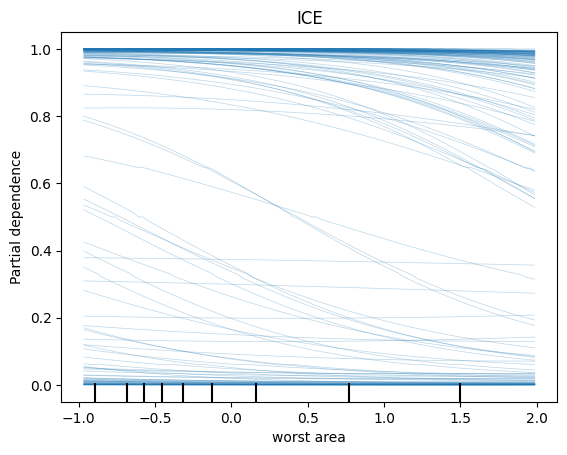

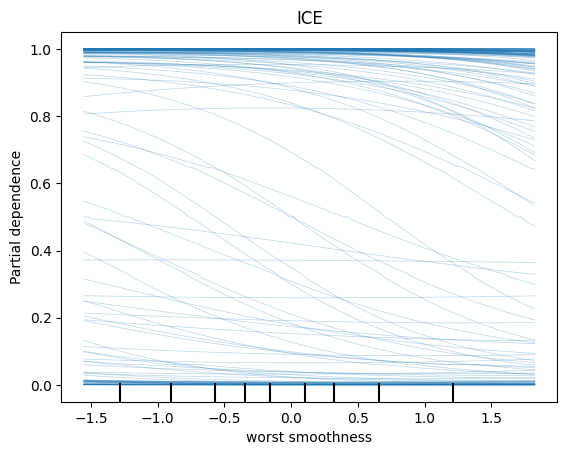

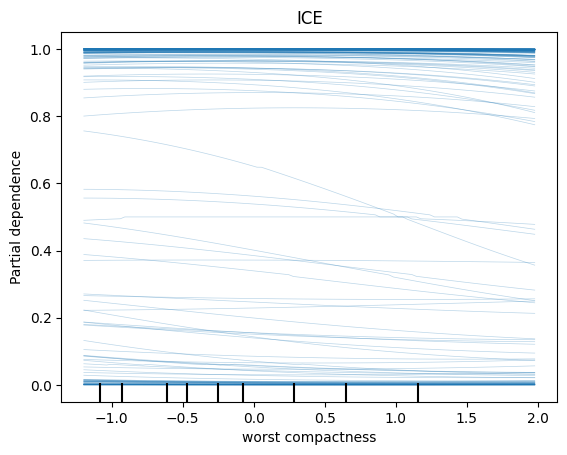

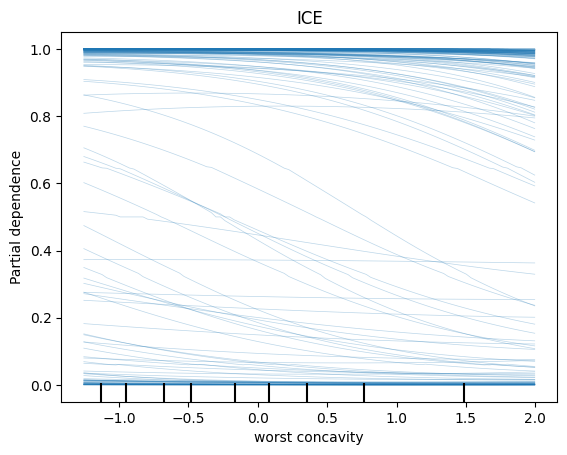

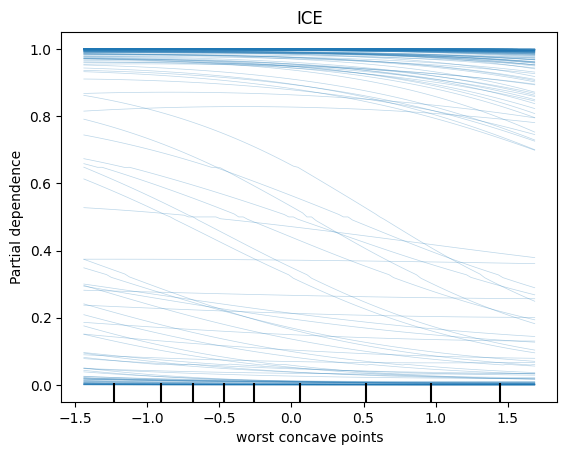

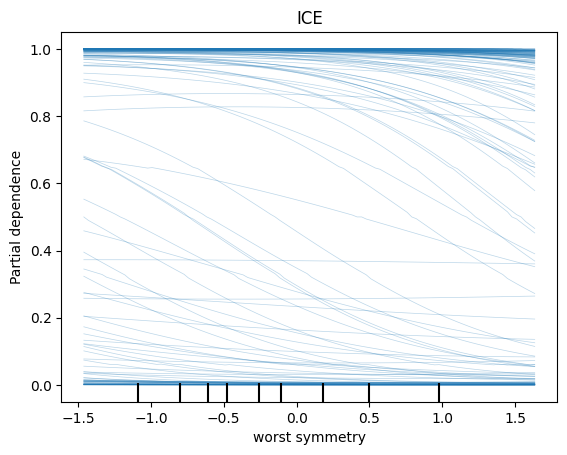

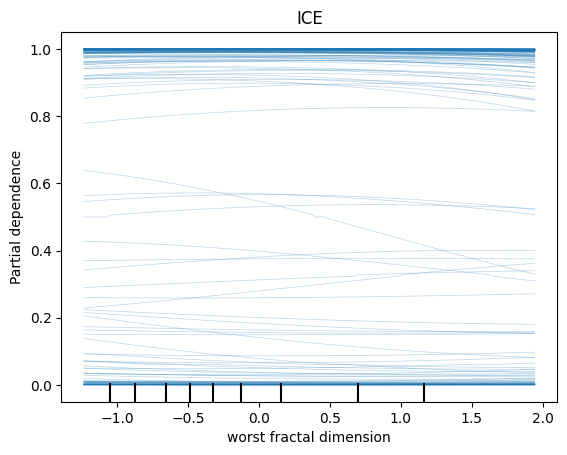

In [25]:
for feature in X.columns.tolist():
    PartialDependenceDisplay.from_estimator(svm, X_val, features=[feature], target=0, kind='individual')
    plt.title("ICE")
    plt.show()

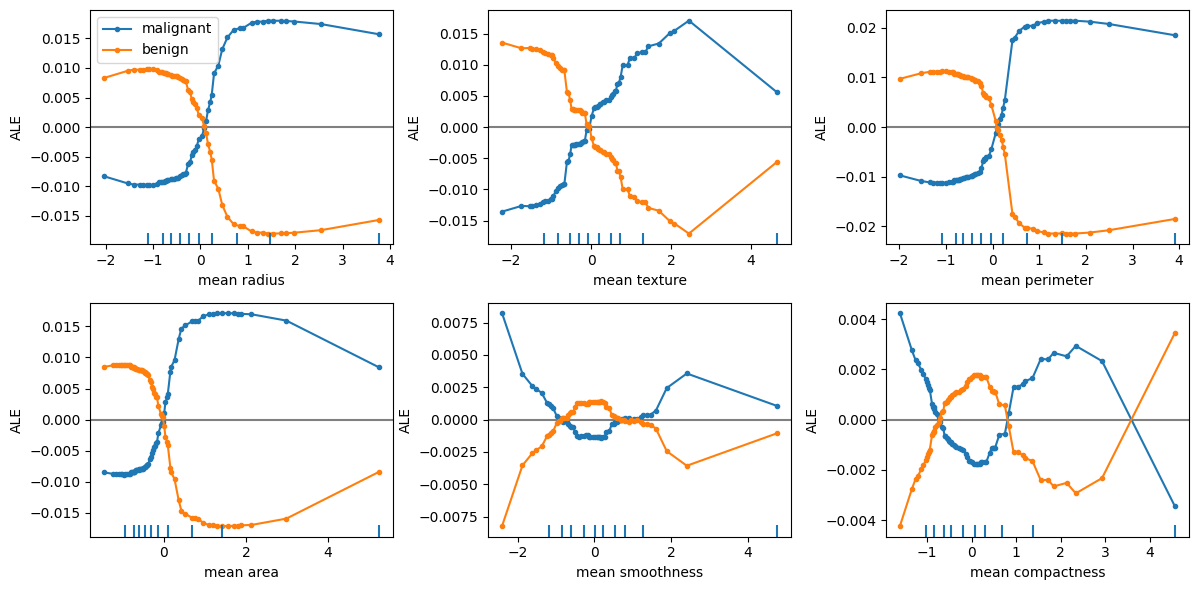

In [26]:
proba_fun_svm = svm.predict_proba
proba_ale_svm = ALE(proba_fun_svm, feature_names=X_train.columns.tolist()[0:6], target_names=data.target_names)
proba_exp_svm = proba_ale_svm.explain(X_train.values)

plot_ale(proba_exp_svm, n_cols=3, fig_kw={'figwidth': 12, 'figheight': 6}, sharey=True)
plt.show()

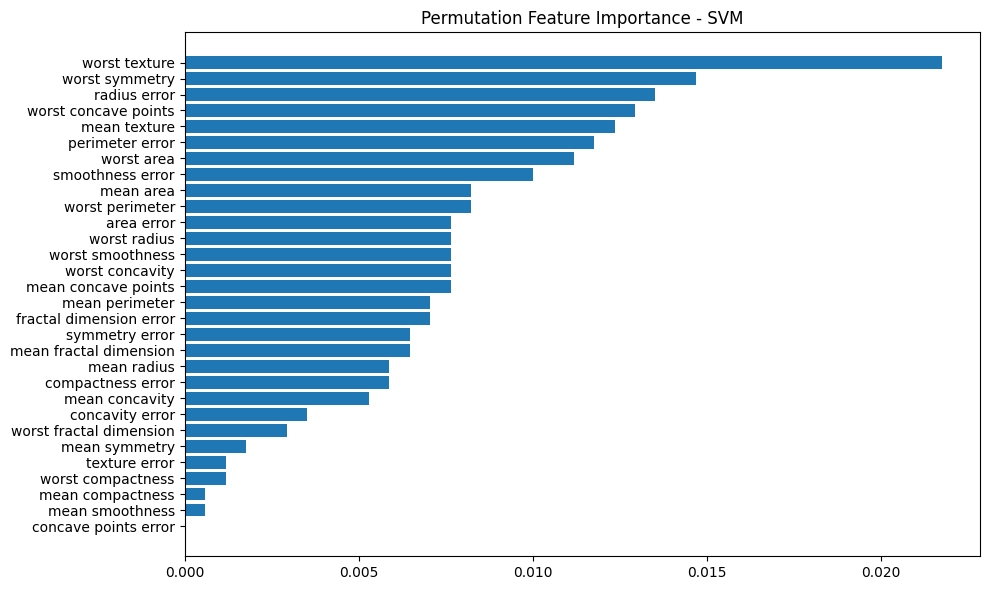

In [27]:
result = permutation_importance(svm, X_val, y_val, n_repeats=10, random_state=42,scoring='accuracy')

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh([X.columns[i] for i in sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance - SVM")
plt.tight_layout()
plt.show()

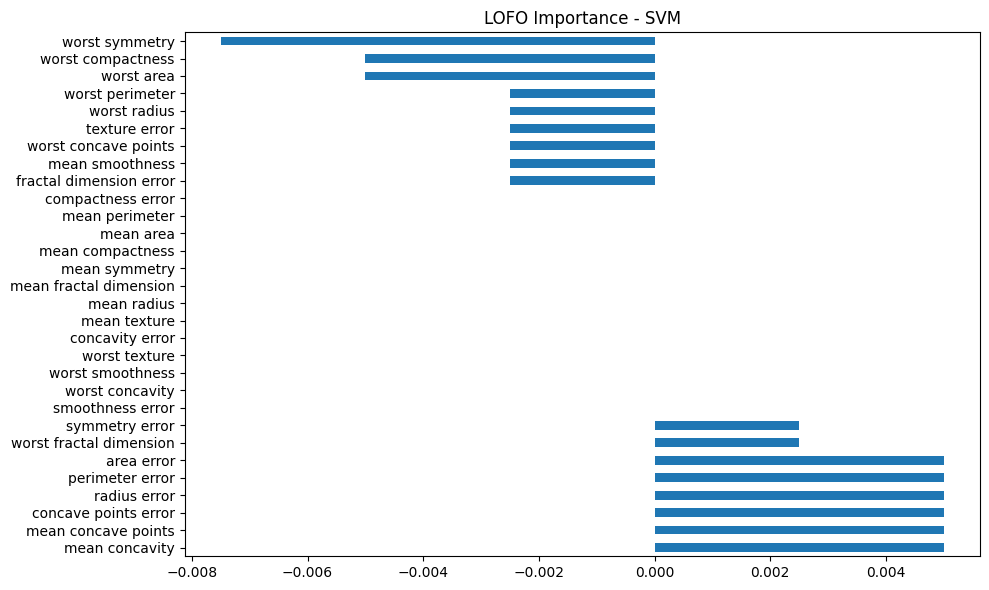

In [28]:
baseline = cross_val_score(svm, X_train, y_train, cv=5).mean()

lofo_scores = {}
for col in X_train.columns:
    X_lofo = X_train.drop(columns=[col])
    score = cross_val_score(svm, X_lofo, y_train, cv=5).mean()
    lofo_scores[col] = baseline - score

lofo_df = pd.Series(lofo_scores).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
lofo_df.plot(kind='barh')
plt.title("LOFO Importance - SVM")
plt.tight_layout()
plt.show()

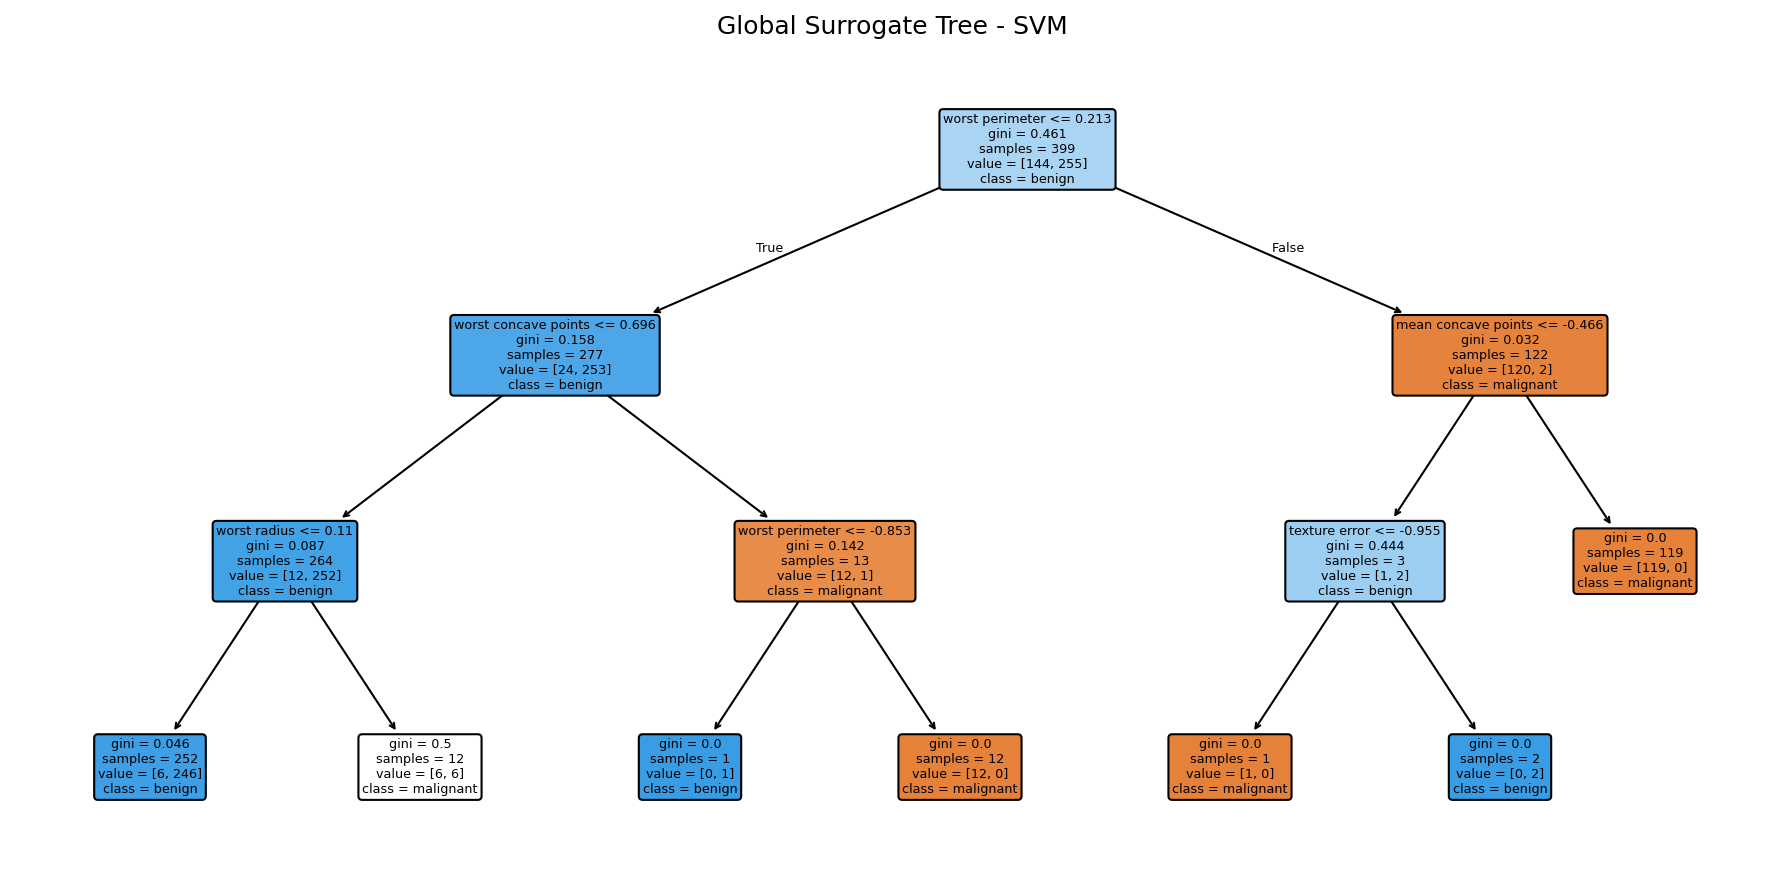

In [29]:
svm_preds = svm.predict(X_train)
surrogate = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate.fit(X_train, svm_preds)

plt.figure(figsize=(12, 6), dpi=150)
tree.plot_tree(surrogate, feature_names=X.columns.tolist(), filled=True, rounded=True, class_names=data.target_names)
plt.title("Global Surrogate Tree - SVM")
plt.tight_layout()
plt.show()

In [30]:
!pip install artemis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 3.1 MB/s eta 0:00:00


In [31]:
!pip install pyartemis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

In [1]:
from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
import random

In [10]:
random.seed(8)
X_exp = random.choices(X_train.values.tolist(), k=100)
X_exp = pd.DataFrame(X_exp, columns=X.columns)

h_stat = FriedmanHStatisticMethod()
h_stat.fit(svm, X_exp)

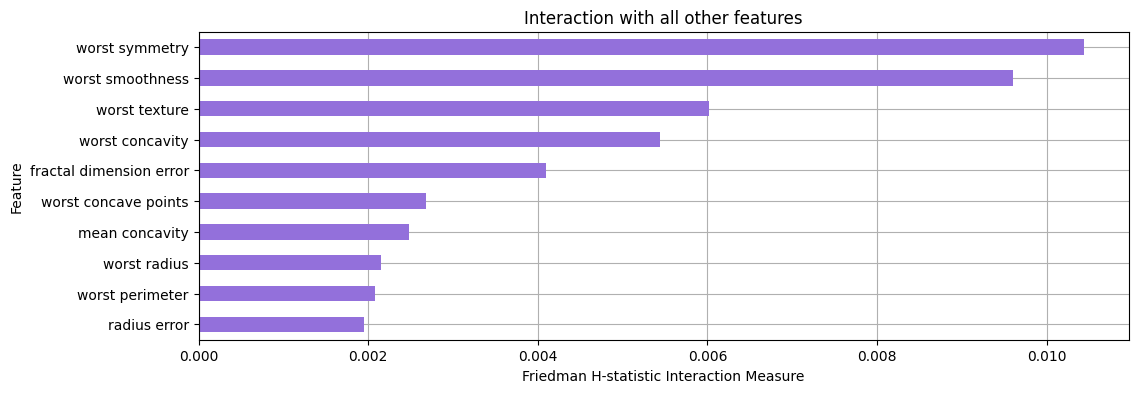

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
h_stat.plot('bar_chart_ova',ax=ax)

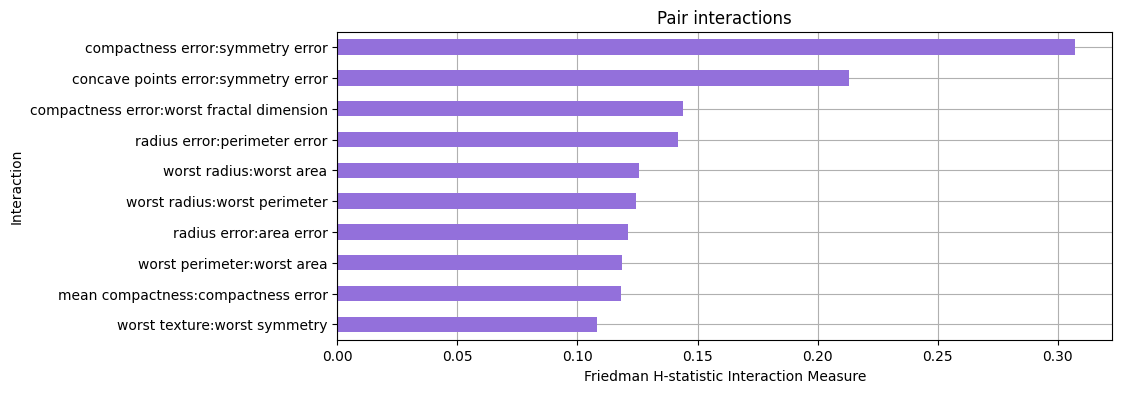

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot(vis_type='bar_chart',ax=ax)

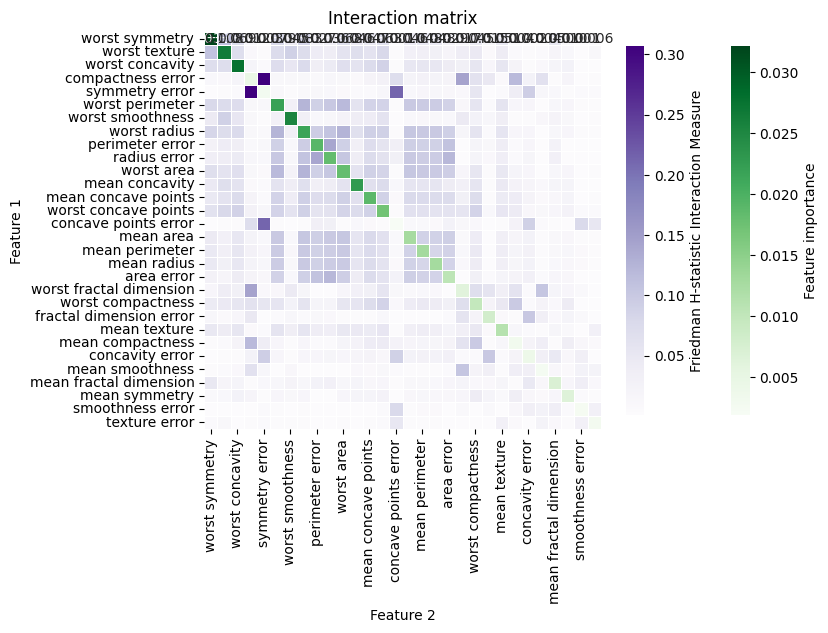

In [16]:
h_stat.plot()

In [11]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=data.target_names.tolist(),
    mode='classification',
    discretize_continuous=True
)

In [12]:
exp = explainer.explain_instance(data_row=X_val.iloc[0],predict_fn=svm.predict_proba,num_features=len(X.columns))
exp.show_in_notebook(show_table=True, show_all=False)

  0%|          | 0/170 [00:00<?, ?it/s]

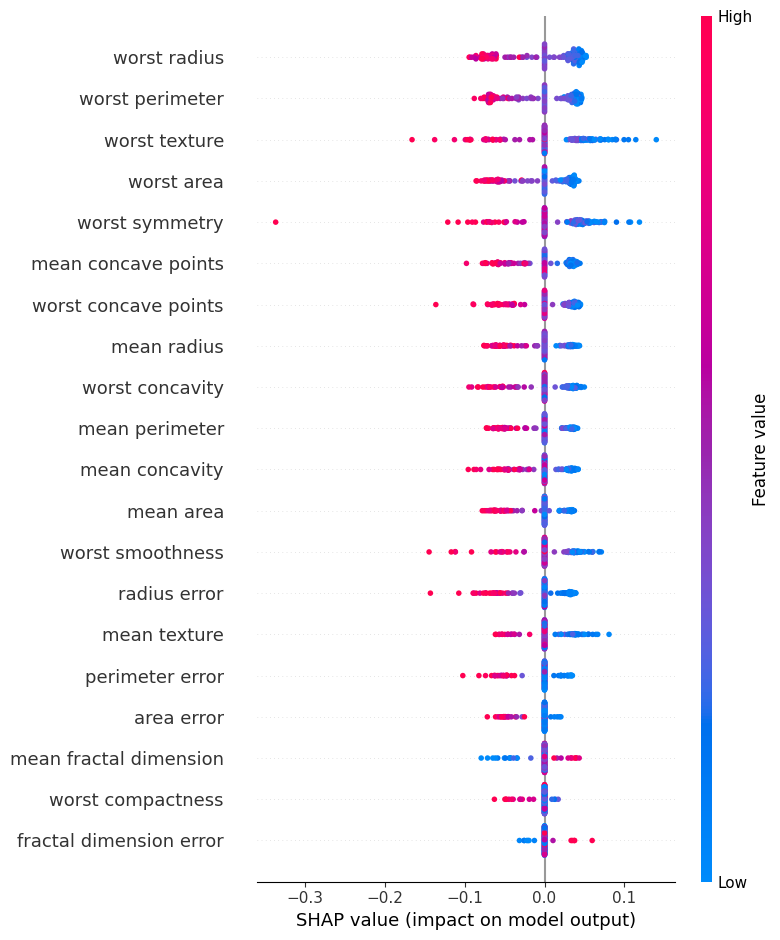

In [13]:
feature_names = X.columns

background_data = shap.sample(X_train, 100)

explainer = shap.KernelExplainer(svm.predict_proba, background_data)

shap_values = explainer.shap_values(X_val)

plt.figure()
shap.summary_plot(shap_values[:, :, 1], X_val, feature_names=feature_names, show=True)
plt.show()

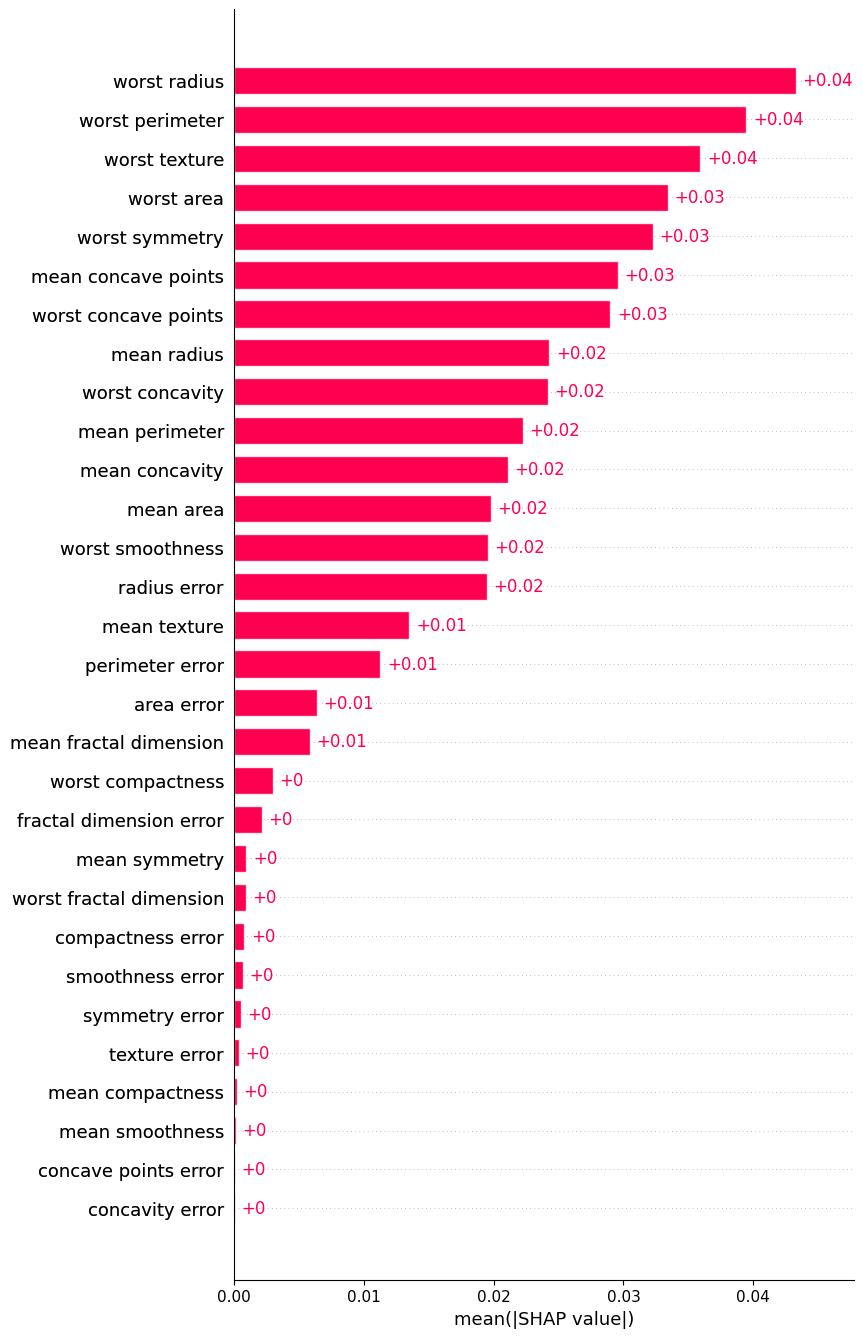

In [18]:
explanation = shap.Explanation(
    values=shap_values[:, :, 1],
    base_values=explainer.expected_value[1],
    data=X_val,
    feature_names=feature_names
)

num_features = len(feature_names)
plt.figure()
shap.plots.bar(explanation, max_display=num_features, show=True)
plt.close()

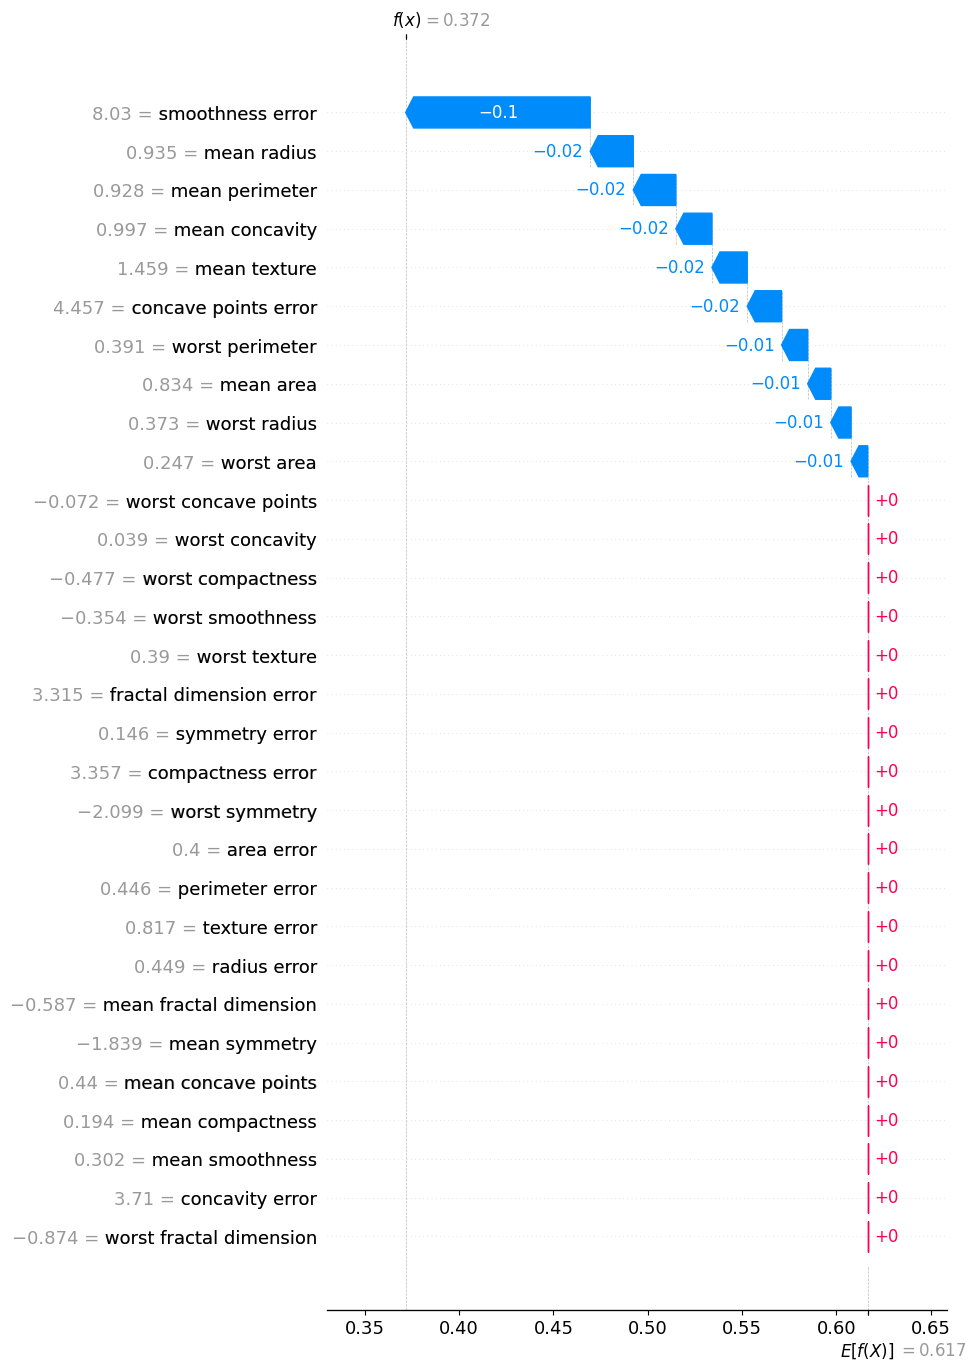

In [19]:
plt.figure()
shap.plots.waterfall(explanation[0], max_display=num_features, show=True)
plt.close()

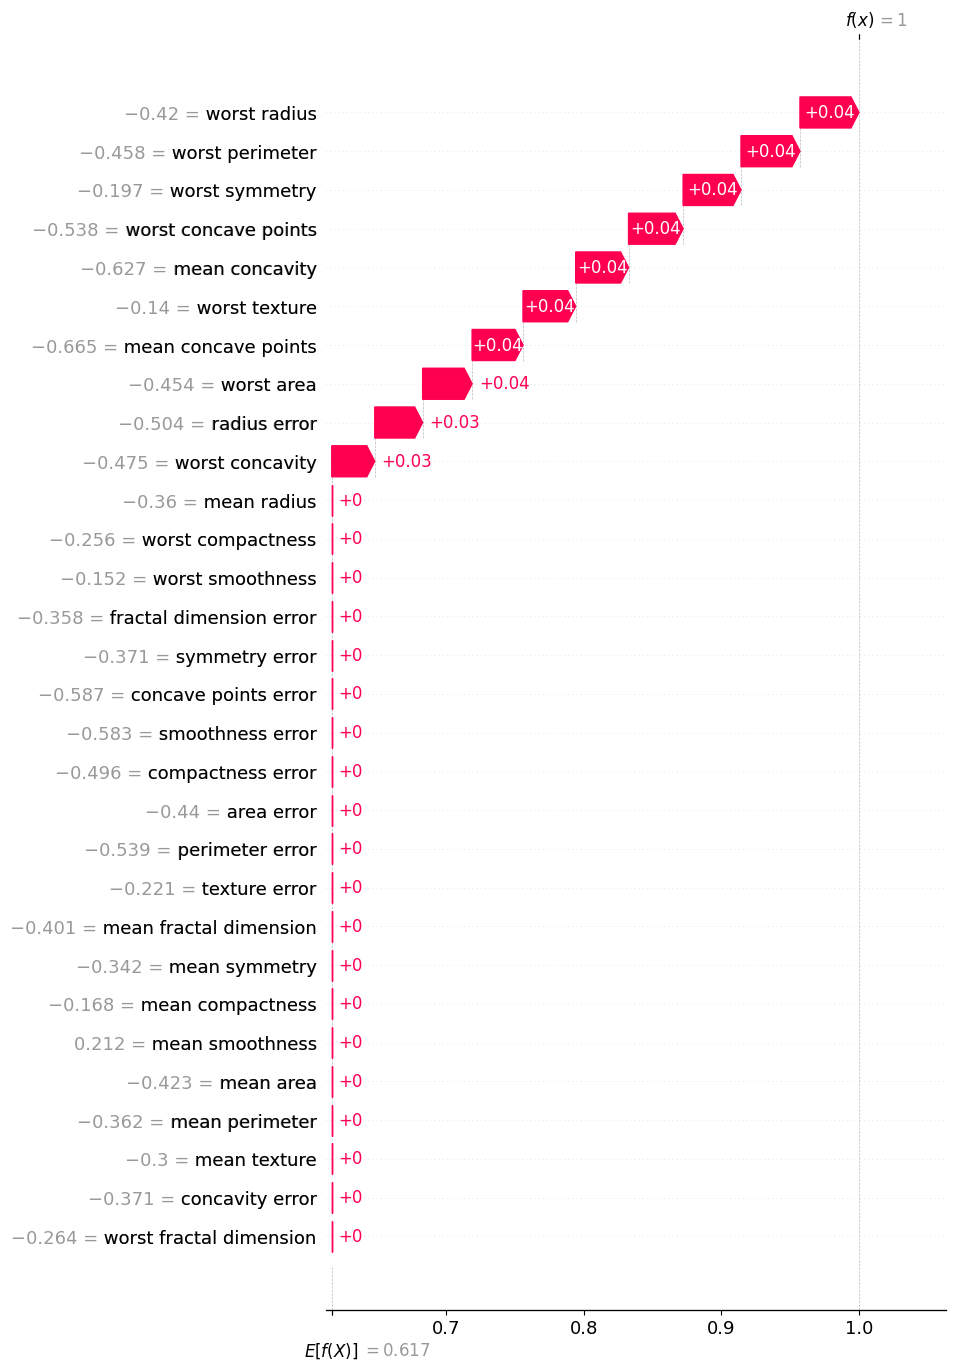

In [20]:
plt.figure()
shap.plots.waterfall(explanation[1], max_display=num_features, show=True)
plt.close()

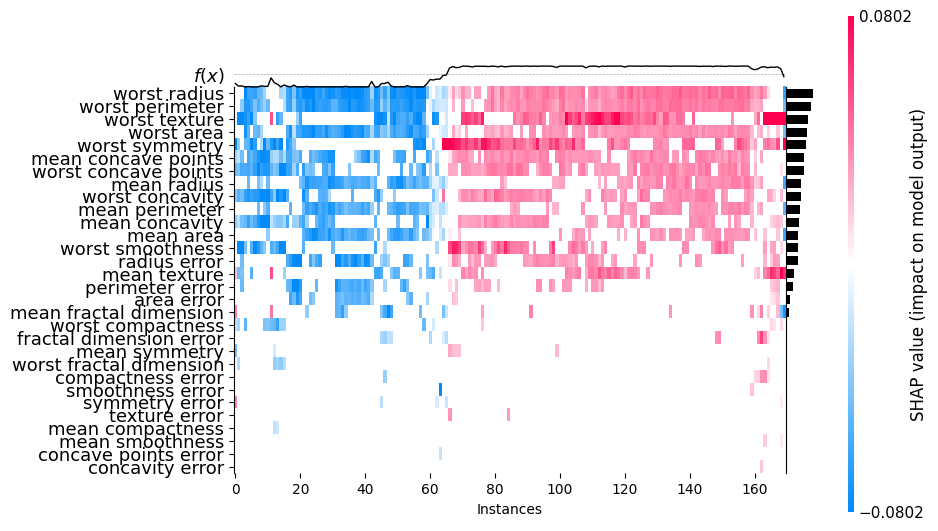

In [21]:
plt.figure()
shap.plots.heatmap(explanation, max_display=num_features, show=True)
plt.close()